<font color="#CA0032"><h1 align="left">**Cajamar Water Footprint**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Tur-IA</h2>

## <font color="#CA3532"> **1. Importar librerías**

In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import time

import torch
import torch.nn as nn

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(123)

## <font color="#CA3532"> **2. Carga de datos**

In [6]:
data = pd.read_table(r'C:\Users\alexc\OneDrive\Documentos\Cajamar_Water_Footprint\data\raw\Modelar_UH2022.txt', sep='|')
data.head()

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0


Como los valores nulos son los decimales y la información que aportan no puede ser muy relevante, los sustituimos por 0

In [7]:
data['READINGTHOUSANDTH'] = data['READINGTHOUSANDTH'].fillna(0)
data['DELTATHOUSANDTH'] = data['DELTATHOUSANDTH'].fillna(0)

Los decimales van entre 0 y 99, así que hacemos una función que divida entre 100 todos aquellos que estén entre 10 y 99, mientras que los queestén entre 1 y 9 los divida entre 10. De esta manera obtenemos la parte decimal para sumarla directamente a la parte entera:

In [8]:
data['READINGTHOUSANDTH_MOD'] = np.where(data['READINGTHOUSANDTH']>9, data['READINGTHOUSANDTH']/100., data['READINGTHOUSANDTH']/10)
data['READING'] = data['READINGINTEGER'] + data['READINGTHOUSANDTH_MOD']

El resultado definitivo lo almacenamos en una nueva columna READING:

Realizamosel mismo proceso en este caso para unir la parte entera y decimal del valor DELTA

In [9]:
data['DELTATHOUSANDTH_MOD'] = np.where(data['DELTATHOUSANDTH']>9, data['DELTATHOUSANDTH']/100., data['DELTATHOUSANDTH']/10)
data['DELTA'] = data['DELTAINTEGER'] + data['DELTATHOUSANDTH_MOD']

EL resultado lo almacenamos en otra columna nueva con el nombre DELTA

Nos creamos un nuevo DataFrame que contenga solo aquellas columnas que nos interesan a partir de ahora para nuestro problema:

In [10]:
data_final = data.drop(['READINGINTEGER', 'READINGTHOUSANDTH', 'DELTAINTEGER', 'DELTATHOUSANDTH', 'READINGTHOUSANDTH_MOD', 'DELTATHOUSANDTH_MOD'], axis=1)

In [11]:
data_final

,ID,SAMPLETIME,READING,DELTA
0,0,2019-06-13 08:34:09,369320.0,17.0
1,0,2019-06-13 17:34:10,369403.0,2.0
2,0,2019-06-13 18:34:10,369403.0,0.0
3,0,2019-06-13 04:34:10,369284.0,1.0
4,0,2019-06-13 14:34:10,369356.0,28.0
...,...,...,...,...
21404823,2749,2019-10-11 06:27:14,164505.0,0.0
21404824,2756,2019-04-06 05:50:17,349758.0,0.0
21404825,2756,2019-04-06 07:50:17,349770.0,12.0
21404826,2756,2019-04-06 04:50:17,349758.0,0.0


In [12]:
from datetime import datetime

In [13]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data_final['SAMPLETIME'] = pd.to_datetime(data_final['SAMPLETIME'],format='%Y-%m-%d %H:%M:%S')
type(data_final['SAMPLETIME'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
def round_hour(data_final):
    aux = []
    for i, time in enumerate(data_final["SAMPLETIME"]):
        aux.append(time.replace(second=0, minute=0))
        
    data_new = data_final.copy()
    data_new["SAMPLETIME"] = aux
    
    return data_new

In [15]:
data_reducida = round_hour(data_final)

In [16]:
data_pivot = pd.pivot_table(data_reducida, values="DELTA", index=["SAMPLETIME"], columns=["ID"])
data_pivot

ID,0,1,2,3,4,5,6,7,8,9,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
SAMPLETIME,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,0.0,0.00,0.0,37.0,14.56,0.0,1.0,5.0,0.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 01:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 02:00:00,0.0,0.00,0.0,0.0,0.00,0.0,9.0,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 03:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 04:00:00,0.0,0.00,0.0,5.0,0.00,0.0,4.0,3.0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00,3.0,1.33,0.0,33.0,3.00,0.0,19.0,0.0,36.46,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31 20:00:00,10.0,1.33,0.0,39.0,37.00,0.0,11.0,0.0,36.46,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31 21:00:00,1.0,1.33,0.0,6.0,2.00,0.0,15.0,0.0,36.46,35.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratamiento de instantes vacíos 

In [17]:
#Fill with 0 the NanValues
data_pivot.fillna(0,inplace=True)
data_pivot

ID,0,1,2,3,4,5,6,7,8,9,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
SAMPLETIME,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,0.0,0.00,0.0,37.0,14.56,0.0,1.0,5.0,0.00,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01 01:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01 02:00:00,0.0,0.00,0.0,0.0,0.00,0.0,9.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01 03:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01 04:00:00,0.0,0.00,0.0,5.0,0.00,0.0,4.0,3.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00,3.0,1.33,0.0,33.0,3.00,0.0,19.0,0.0,36.46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31 20:00:00,10.0,1.33,0.0,39.0,37.00,0.0,11.0,0.0,36.46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31 21:00:00,1.0,1.33,0.0,6.0,2.00,0.0,15.0,0.0,36.46,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data_pivot.reset_index(inplace=True)
data_pivot['SAMPLETIME'] = pd.to_datetime(data_pivot['SAMPLETIME'])

In [19]:
from datetime import datetime
train_test_split = datetime.strptime("31.01.2020 23:00:01", "%d.%m.%Y %H:%M:%S")
df_train = data_pivot.loc[data_pivot["SAMPLETIME"] < train_test_split]
df_test = data_pivot.loc[data_pivot["SAMPLETIME"] >= train_test_split]

In [20]:
df_train

ID,SAMPLETIME,0,1,2,3,4,5,6,7,8,...,2739,2742,2743,2744,2745,2746,2747,2748,2749,2756
0,2019-02-01 00:00:00,0.0,0.00,0.0,37.0,14.56,0.0,1.0,5.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02-01 01:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-01 02:00:00,0.0,0.00,0.0,0.0,0.00,0.0,9.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-02-01 03:00:00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-02-01 04:00:00,0.0,0.00,0.0,5.0,0.00,0.0,4.0,3.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,2020-01-31 19:00:00,3.0,1.33,0.0,33.0,3.00,0.0,19.0,0.0,36.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8755,2020-01-31 20:00:00,10.0,1.33,0.0,39.0,37.00,0.0,11.0,0.0,36.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,2020-01-31 21:00:00,1.0,1.33,0.0,6.0,2.00,0.0,15.0,0.0,36.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,2020-01-31 22:00:00,9.0,1.33,10.0,30.0,4.00,0.0,0.0,0.0,36.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from sklearn.preprocessing import MinMaxScaler
data_list = [i for i in data_pivot.columns if i != "SAMPLETIME"]
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[data_list])
#scaled_test = scaler.transform(df_test[data_list])

In [22]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
# Take into consideration last 6 hours, and perform forecasting for next 1 hour

LOOK_BACK = 24*3
FORECAST_RANGE = 1
n_features = len(data_list)
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
#X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

(8687, 72, 2747)
(8687, 1, 2747)


### Funciones de evaluación

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

In [25]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [26]:
checkpoint_filepath = "path_to_checkpoint_filepath"
checkpoint_callback = ModelCheckpoint(
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor="val_loss",
 mode="min",
 save_best_only=True)
early_stopping_callback = EarlyStopping(
 monitor="val_loss",
 min_delta=0.0005,
 patience=10,
 mode="min"
)
rlrop_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.2, mode="min", patience=3, min_lr=0.001)

In [27]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [28]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

### Encoder-Decoder Model

In [29]:
epochs = 50
batch_size = 32
validation = 0.01

In [30]:
model_enc_dec = Sequential()

model_enc_dec.add(LSTM(100, activation="tanh", input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation="tanh", return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features,activation="tanh")))
model_enc_dec.compile(optimizer="adam", loss="mse")
print("Aqui bien")
#plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
#yhat = model_enc_dec.predict(X_test, verbose=0)
#yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
#evaluate_forecast(y_test_inverse, yhat_inverse)

Aqui bien
Epoch 1/50
269/269 [==============================] - ETA: 0s - loss: 0.0053

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 63s 224ms/step - loss: 0.0053 - val_loss: 0.0055 - lr: 0.0010
Epoch 2/50
269/269 [==============================] - ETA: 0s - loss: 0.0045

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 58s 217ms/step - loss: 0.0045 - val_loss: 0.0053 - lr: 0.0010
Epoch 3/50
269/269 [==============================] - ETA: 0s - loss: 0.0044

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 58s 217ms/step - loss: 0.0044 - val_loss: 0.0052 - lr: 0.0010
Epoch 4/50
269/269 [==============================] - ETA: 0s - loss: 0.0043

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 62s 232ms/step - loss: 0.0043 - val_loss: 0.0051 - lr: 0.0010
Epoch 5/50
269/269 [==============================] - ETA: 0s - loss: 0.0042

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 66s 245ms/step - loss: 0.0042 - val_loss: 0.0050 - lr: 0.0010
Epoch 6/50
269/269 [==============================] - ETA: 0s - loss: 0.0041

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 68s 254ms/step - loss: 0.0041 - val_loss: 0.0050 - lr: 0.0010
Epoch 7/50
269/269 [==============================] - ETA: 0s - loss: 0.0041

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 68s 253ms/step - loss: 0.0041 - val_loss: 0.0050 - lr: 0.0010
Epoch 8/50
269/269 [==============================] - ETA: 0s - loss: 0.0040

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath\assets


269/269 [==============================] - 72s 269ms/step - loss: 0.0040 - val_loss: 0.0050 - lr: 0.0010
Epoch 9/50
 61/269 [=====>........................] - ETA: 55s - loss: 0.0040

KeyboardInterrupt: 

In [31]:
#Convertimos el array en un array 3d con las últimas 6 horas del conjunto de entrenamiento
X_test = X_train[-1,:,:].reshape((1,LOOK_BACK,2747))
preds = []

semanas = 2
instantes_predecir = semanas*7*24

for i in range(instantes_predecir):
    #Predecimos el siguiente valor a partir de los 6 últimos instantes
    prediccion = model_enc_dec.predict(X_test)
    
    #Los vamos almacenando en una lista
    preds.append(prediccion.squeeze())
    
    #Actualizamos el conjunto de test eliminando el instante más antiguo y añadiendo la prediccion
    X_test = np.delete(X_test,(0),axis=1)
    aux = prediccion.squeeze(1)
    X_test = np.vstack([X_test.squeeze(), aux])
    X_test = X_test.reshape((1,LOOK_BACK,2747))
    
preds = np.array(preds)

In [56]:
preds.shape

(336, 2747)

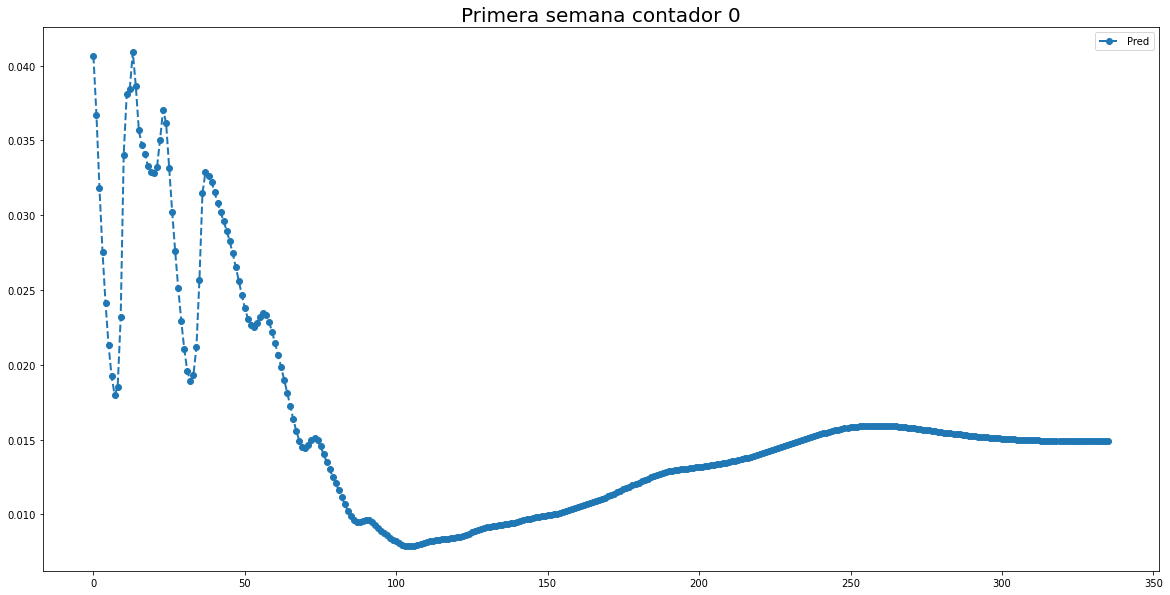

In [42]:
contador = 1099

plt.figure(figsize=(20,10))
plt.plot(range(len(preds[:])), preds[:,contador], '.',linestyle='dashed',
     linewidth=2, markersize=12)
plt.legend(["Pred"])
plt.title('Primera semana contador 0', fontsize=20);

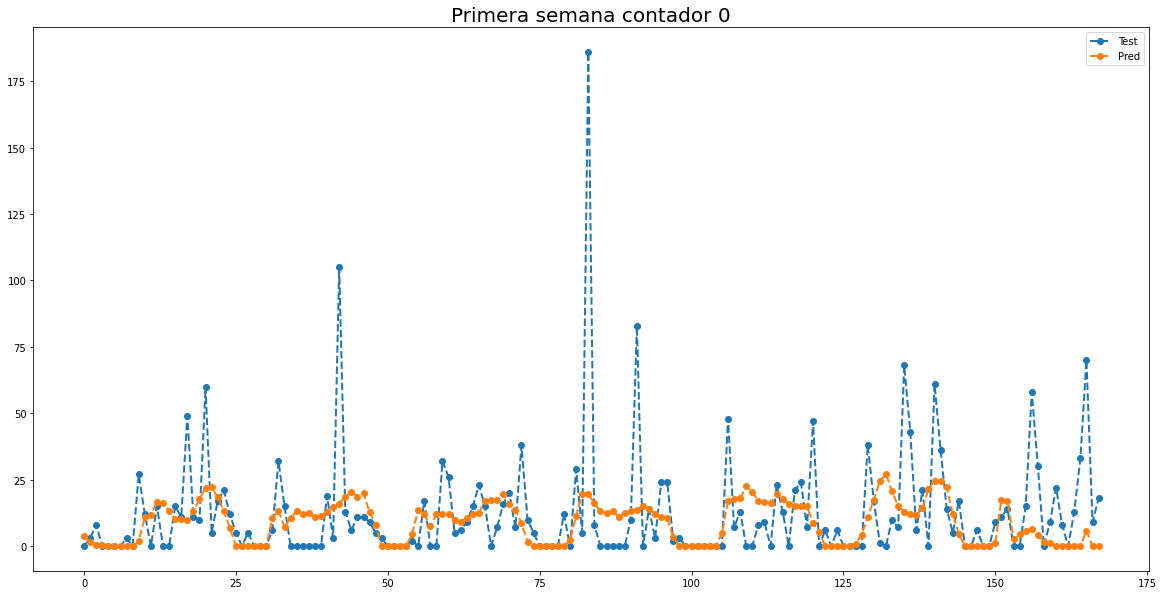

In [130]:
contador = 0

plt.figure(figsize=(20,10))
plt.plot(range(len(y_test_inverse[:168,contador])), y_test_inverse[:168,contador], '.',linestyle='dashed',
     linewidth=2, markersize=12)
plt.plot(range(len(y_test_inverse[:168,contador])), yhat_inverse[:168,contador], '.',linestyle='dashed',
     linewidth=2, markersize=12)
plt.legend(["Test","Pred"])
plt.title('Primera semana contador 0', fontsize=20);

In [60]:
def test_dias(y_test,y_pred):
    y_test_dias, y_pred_dias = [],[]
    for i in range(0,len(y_pred),24):
        y_test_dias.append(y_test[i:i+24,:].sum(axis=0))
        y_pred_dias.append(y_pred[i:i+24,:].sum(axis=0))
        
    return np.array(y_test_dias), np.array(y_pred_dias)

In [61]:
def test_2semanas(y_test,y_pred):
    y_test_2semanas, y_pred_2semanas = [],[]
    for i in range(0,len(y_pred),24*7):
        y_test_2semanas.append(y_test[i:i+24*7,:].sum(axis=0))
        y_pred_2semanas.append(y_pred[i:i+24*7,:].sum(axis=0))
        
    return np.array(y_test_2semanas), np.array(y_pred_2semanas)

In [62]:
#y_test_dias, y_pred_dias = test_dias(y_test_inverse,yhat_inverse)
#y_test_2semanas, y_pred_2semanas = test_2semanas(y_test_inverse,yhat_inverse)

_, y_pred_dias = test_dias(np.array([[0],[0]]),y_pred=preds)
_, y_pred_2semanas = test_2semanas(np.array([[0],[0]]),y_pred=preds)

In [64]:
print("Comprobamos que las sumas coinciden:\n")
#print(f"Suma de las primeras 24 horas: {y_test_inverse[:24,0].sum()}")
#print(f"Consumo primer dia: {y_test_dias[0,0]}\n")
#print(f"Suma de las primeras 168 horas: {y_test_inverse[:168,0].sum()}")
#print(f"Consumo primera semana: {y_test_2semanas[0,0]}")

print(f"Suma de las primeras 24 horas: {preds[:24,0].sum()}")
print(f"Consumo primer dia: {y_pred_dias[0,0]}\n")
print(f"Suma de las primeras 168 horas: {preds[:168,0].sum()}")
print(f"Consumo primera semana: {y_pred_2semanas[0,0]}")

Comprobamos que las sumas coinciden:

Suma de las primeras 24 horas: 1.1245744228363037
Consumo primer dia: 1.1245743036270142

Suma de las primeras 168 horas: 8.358892440795898
Consumo primera semana: 8.358894348144531


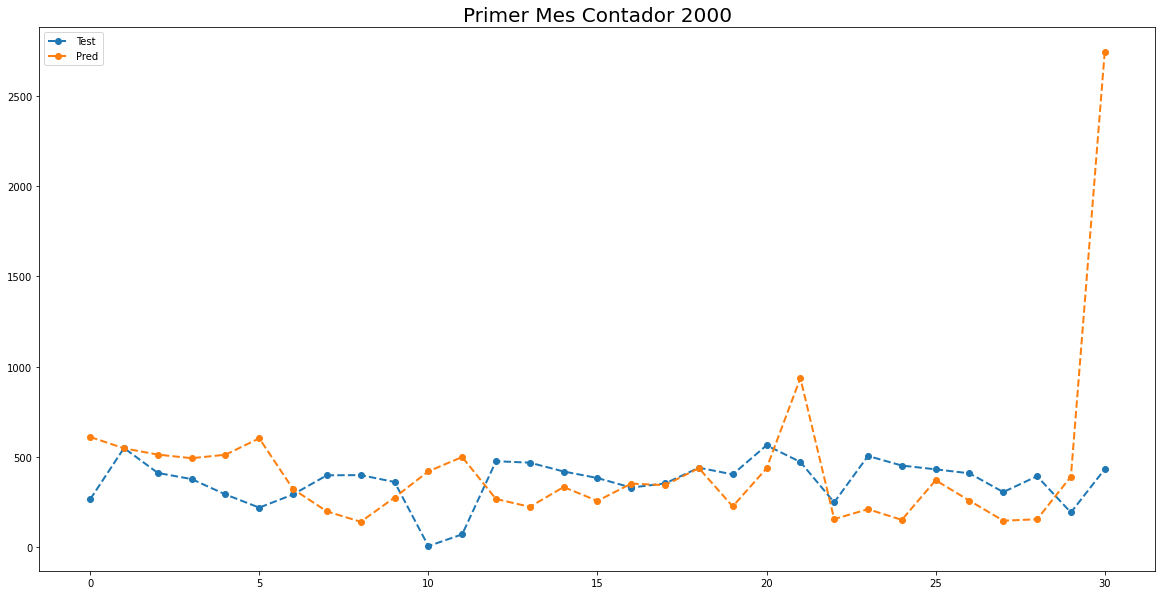

In [211]:
contador = 2000

plt.figure(figsize=(20,10))
plt.plot(range(len(y_test_dias[:,contador])), y_test_dias[:168,contador], '.',linestyle='dashed',
     linewidth=2, markersize=12)
plt.plot(range(len(y_pred_dias[:,contador])), y_pred_dias[:,contador], '.',linestyle='dashed',
     linewidth=2, markersize=12)
plt.legend(["Test","Pred"])
plt.title(f'Primer Mes Contador {contador}', fontsize=20);

In [65]:
import os
def save_results(ids, y_pred_dias, y_pred_2semanas):
    matriz = pd.DataFrame()
    matriz["ID"] = ids
    matriz["Dia_1"] = y_pred_dias[0,:]
    matriz["Dia_2"] = y_pred_dias[1,:]
    matriz["Dia_3"] = y_pred_dias[2,:]
    matriz["Dia_4"] = y_pred_dias[3,:]
    matriz["Dia_5"] = y_pred_dias[4,:]
    matriz["Dia_6"] = y_pred_dias[5,:]
    matriz["Dia_7"] = y_pred_dias[6,:]
    matriz["Semana_1"] = y_pred_2semanas[0,:]
    matriz["Semana_2"] = y_pred_2semanas[1,:]

    matriz['Dia_1'] = matriz['Dia_1'].apply(lambda x: round(x, 2))
    matriz['Dia_2'] = matriz['Dia_2'].apply(lambda x: round(x, 2))
    matriz['Dia_3'] = matriz['Dia_3'].apply(lambda x: round(x, 2))
    matriz['Dia_4'] = matriz['Dia_4'].apply(lambda x: round(x, 2))
    matriz['Dia_5'] = matriz['Dia_5'].apply(lambda x: round(x, 2))
    matriz['Dia_6'] = matriz['Dia_6'].apply(lambda x: round(x, 2))
    matriz['Dia_7'] = matriz['Dia_7'].apply(lambda x: round(x, 2))
    matriz['Semana_1'] = matriz['Semana_1'].apply(lambda x: round(x, 2))
    matriz['Semana_2'] = matriz['Semana_2'].apply(lambda x: round(x, 2))

    matriz.to_csv("Resultados_1.txt",sep="|",index=False, header=False)

In [66]:
y_pred_dias.shape

(14, 2747)

In [67]:
save_results(ids=np.array(data_final["ID"].unique()),y_pred_dias= y_pred_dias,y_pred_2semanas=y_pred_2semanas)

### CNN Encoder Decoder LSTM 

In [214]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation="relu", input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation="relu"))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation="relu", return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation="relu")))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss="mse", optimizer="adam")

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_3. Consider increasing the input size. Received input shape [None, 6, 2747] which would produce output shape with a zero or negative value in a dimension.

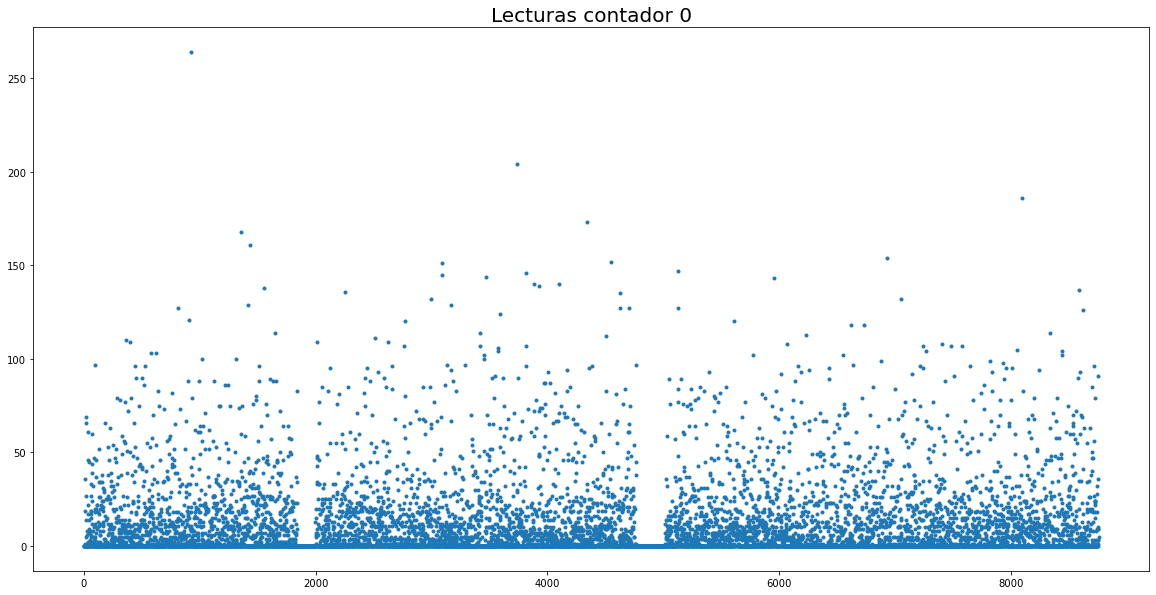

In [88]:
plt.figure(figsize=(20,10))
plt.plot(range(len(DELTAS_FULL[0,:])), DELTAS_FULL[0,:], '.')
plt.title('Lecturas contador 0',
          fontsize=20);

In [365]:
data_cont_0 = data_final[data_final['ID'] == 0]
data_cont_0.sort_values('SAMPLETIME', inplace=True)
data_cont_0

<ipython-input-365-173ba0211841>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cont_0.sort_values('SAMPLETIME', inplace=True)


,ID,SAMPLETIME,READING,DELTA
160,0,2019-02-01 00:39:36,331710.0,0.0
152,0,2019-02-01 01:39:36,331710.0,0.0
150,0,2019-02-01 02:39:35,331710.0,0.0
156,0,2019-02-01 03:39:35,331710.0,0.0
161,0,2019-02-01 04:39:35,331710.0,0.0
...,...,...,...,...
5110,0,2020-01-31 19:24:45,434941.0,3.0
5112,0,2020-01-31 20:24:45,434951.0,10.0
5114,0,2020-01-31 21:24:45,434952.0,1.0
5109,0,2020-01-31 22:24:45,434961.0,9.0


In [72]:
data_cont_0_mean = data_cont_0.groupby(['DATE']).mean()
data_cont_0_mean

,ID,READING,DELTA,DAY_YEAR,DAY,MONTH,YEAR
DATE,,,,,,,
2019-02-01,0,331806.625000,10.125000,32,1,2,2019
2019-02-02,0,332045.666667,9.833333,33,2,2,2019
2019-02-03,0,332302.625000,13.958333,34,3,2,2019
2019-02-04,0,332601.083333,10.500000,35,4,2,2019
2019-02-05,0,332873.833333,9.166667,36,5,2,2019
...,...,...,...,...,...,...,...
2020-01-27,0,433500.416667,8.875000,27,27,1,2020
2020-01-28,0,433725.875000,9.666667,28,28,1,2020
2020-01-29,0,434032.083333,16.791667,29,29,1,2020


In [75]:
fechas = data_cont_0_mean.index
target = data_cont_0_mean['READING'].values

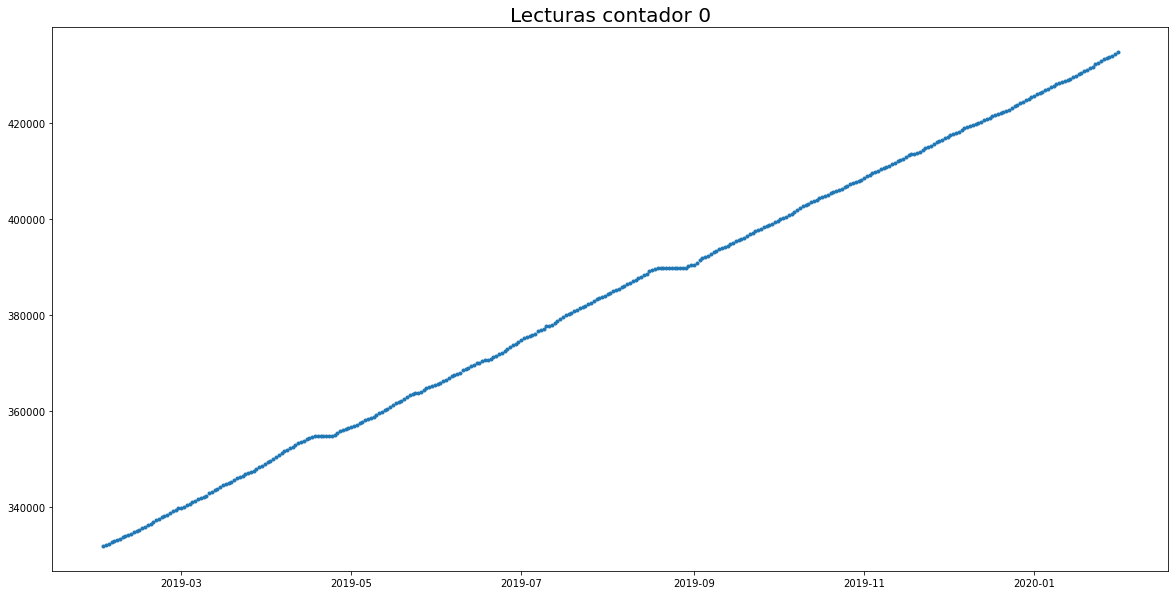

In [80]:
plt.figure(figsize=(20,10))
plt.plot(fechas, target, '.')
plt.title('Lecturas contador 0',
          fontsize=20);

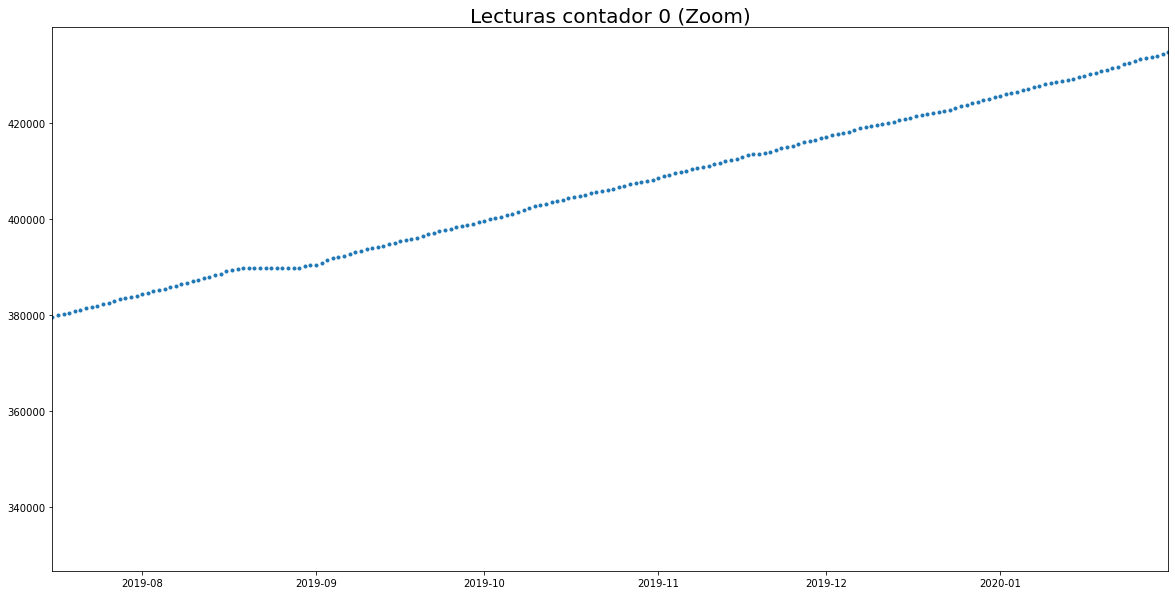

In [83]:
plt.figure(figsize=(20,10))
plt.plot(fechas, target, '.')
plt.title('Lecturas contador 0 (Zoom)', fontsize=20)
plt.xlim([fechas[-200],fechas[-1]]);

In [84]:
fechas = data_cont_0_mean.index
target = data_cont_0_mean['DELTA'].values

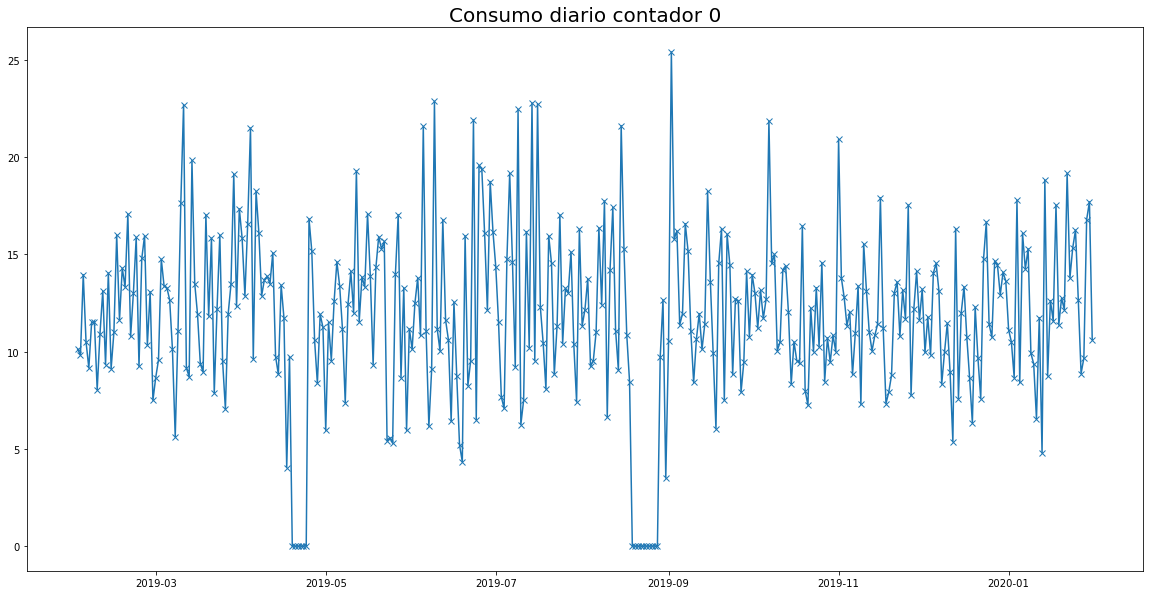

In [87]:
plt.figure(figsize=(20,10))
plt.plot(fechas, target, 'x-')
plt.title('Consumo diario contador 0',
          fontsize=20);